In [36]:
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

## Reading the data 

In [3]:
data = pd.read_csv('co2-mm-gl.csv')
data.head()

,Date,Decimal Date,Average,Trend
0,1980-01-01,1980.042,338.45,337.82
1,1980-02-01,1980.125,339.14,338.10
2,1980-03-01,1980.208,339.46,338.12
3,1980-04-01,1980.292,339.86,338.24
4,1980-05-01,1980.375,340.30,338.77


In [4]:
data = data.set_index('Date')

## Plotting CO2 concentration over time

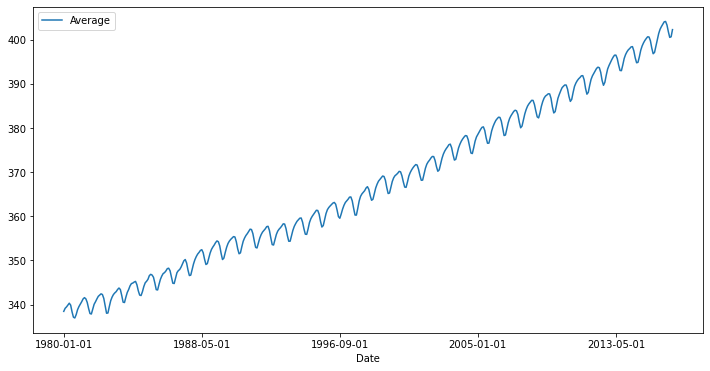

In [5]:
plt.plot(data[["Average"]]).plot(figsize=(12,6))

## Creating the `Average Diff` column

In [6]:
data["Average Diff"] = data["Average"] - data["Average"].shift(1).fillna(method='bfill')
data.head()

,Decimal Date,Average,Trend,Average Diff
Date,,,,
1980-01-01,1980.042,338.45,337.82,0.00
1980-02-01,1980.125,339.14,338.10,0.69
1980-03-01,1980.208,339.46,338.12,0.32
1980-04-01,1980.292,339.86,338.24,0.40
1980-05-01,1980.375,340.30,338.77,0.44


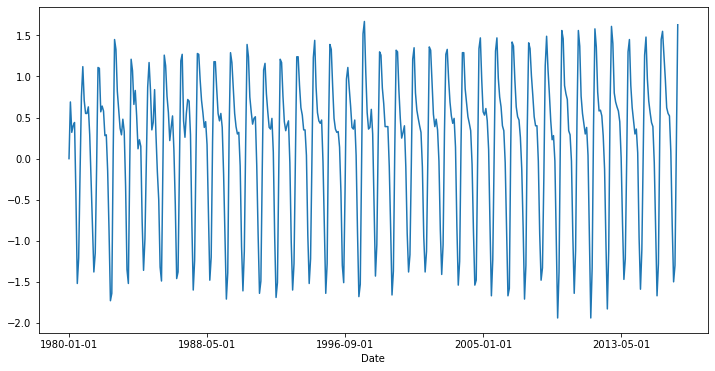

In [7]:
data["Average Diff"].plot(figsize=(12,6))

## Generating time-series data for the model

In [8]:
def generate_data(co2_arr,n_seq):
    x, y = [],[]
    for i in range(co2_arr.shape[0]-n_seq):
        x.append(co2_arr[i:i+n_seq-1])
        y.append(co2_arr[i+n_seq-1:i+n_seq])
    x = np.array(x).reshape(-1,n_seq-1,1)
    y = np.array(y)
    return x,y

x, y = generate_data(data["Average Diff"].values, 13)

print(data["Average Diff"].values[:20])
print()
i = 0
for xx, yy in zip(x,y):
    print('x: ',xx.ravel(), ' y: ', yy.ravel())
    i += 1
    if i>5: break

[ 0.    0.69  0.32  0.4   0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71
  0.55  0.55  0.63  0.29 -0.27 -0.81 -1.38 -1.15]

x:  [ 0.    0.69  0.32  0.4   0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71]  y:  [0.55]
x:  [ 0.69  0.32  0.4   0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71  0.55]  y:  [0.55]
x:  [ 0.32  0.4   0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71  0.55  0.55]  y:  [0.63]
x:  [ 0.4   0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71  0.55  0.55  0.63]  y:  [0.29]
x:  [ 0.44 -0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71  0.55  0.55  0.63  0.29]  y:  [-0.27]
x:  [-0.44 -1.52 -1.21 -0.18  0.76  1.12  0.71  0.55  0.55  0.63  0.29 -0.27]  y:  [-0.81]


## Defining and training the model 

In [10]:
rnn = models.Sequential([
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
rnn.compile(loss='mse', optimizer='adam')

In [11]:
rnn.fit(x, y, shuffle=True, batch_size=64, epochs=25)

(429, 12, 1)
Train on 429 samples
Epoch 1/25
429/429 [==============================] - 1s 3ms/sample - loss: 0.5398
Epoch 2/25
429/429 [==============================] - 0s 210us/sample - loss: 0.0728
Epoch 3/25
429/429 [==============================] - 0s 233us/sample - loss: 0.0425
Epoch 4/25
429/429 [==============================] - 0s 209us/sample - loss: 0.0308
Epoch 5/25
429/429 [==============================] - 0s 232us/sample - loss: 0.0258
Epoch 6/25
429/429 [==============================] - 0s 210us/sample - loss: 0.0255
Epoch 7/25
429/429 [==============================] - 0s 233us/sample - loss: 0.0236
Epoch 8/25
429/429 [==============================] - 0s 256us/sample - loss: 0.0222
Epoch 9/25
429/429 [==============================] - 0s 257us/sample - loss: 0.0206
Epoch 10/25
429/429 [==============================] - 0s 233us/sample - loss: 0.0199
Epoch 11/25
429/429 [==============================] - 0s 233us/sample - loss: 0.0202
Epoch 12/25
429/429 [==========

## Predicting using the trained model

In [12]:
history = data["Average Diff"].values[-12:].reshape(1,-1,1)
true_vals = []
prev_true = data["Average"].values[-1]
for i in range(60):
    p_diff = rnn.predict(history).reshape(1,-1,1)
    history = np.concatenate((history[:,1:,:],p_diff),axis=1)
    true_vals.append(prev_true+p_diff[0,0,0])
    prev_true = true_vals[-1]
    
print("Predictions: {}".format(true_vals[:10]))

[403.75853806495667, 404.6112694120407, 405.31186175107956, 405.8652423596382, 406.29235762119293, 406.7205581045151, 406.80860092252493, 405.9937806329131, 404.43099524587393, 403.1875214776397, 403.3105981326103, 404.60974776506424, 405.9307577586174, 406.82166212558747, 407.46084117650986, 407.9580514407158, 408.3956437385082, 408.8185496902466, 408.8766224770248, 408.09944025561214, 406.54679588362575, 405.2454617409408, 405.3090712739527, 406.59078630939126, 407.9129144860804, 408.80821958318353, 409.44475051894784, 409.92530858650804, 410.35383039847017, 410.789006562382, 410.85773503914476, 410.0963971032202, 408.5547019852698, 407.2306540621817, 407.25654343277216, 408.525718485415, 409.8551484695077, 410.7529592266679, 411.38987616211176, 411.8670396259427, 412.2925431779027, 412.7332412353158, 412.8139607807994, 412.06723814219237, 410.53359489649534, 409.1971226236224, 409.19656353671104, 410.4540033884719, 411.78743963915855, 412.68806868273765, 413.32527595240623, 413.8019

## Plotting the current values and predictions 

Text(0.5, 1.0, 'Evolution of CO2 Concentration over Time')

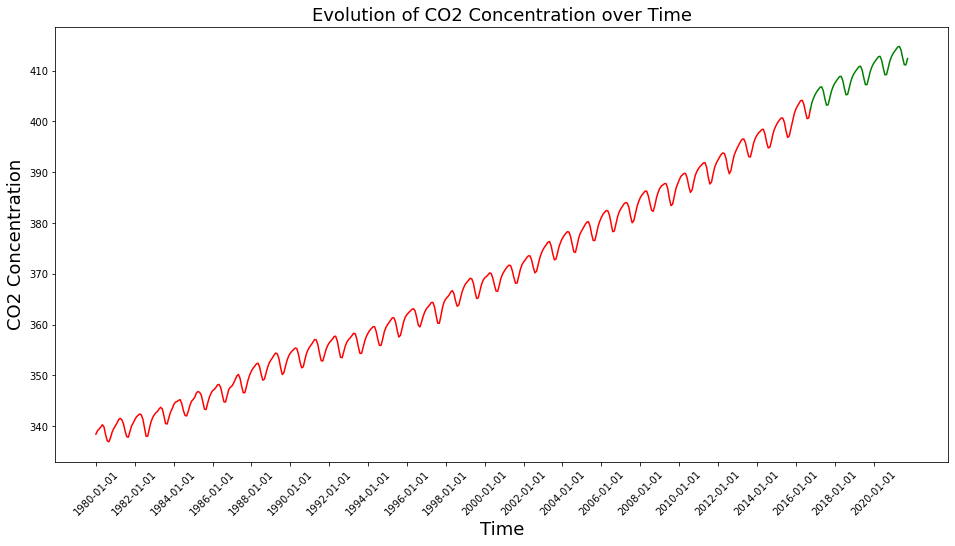

In [35]:
plt.figure(figsize=(16,8))
plt.plot(data["Average"], c='r')
pred_ser = pd.Series(
    [data["Average"].values[-1]]+true_vals, 
    index=[data.index[-1]]+[pd.to_datetime(data.index[-1], format="%Y-%m-%d")+pd.DateOffset(months=i+1) for i in range(60)]
)
pred_ser.index = pd.to_datetime(pred_ser.index).strftime('%Y-%m-%d')
plt.plot(
    pred_ser, c='g')
plt.xticks(np.arange(0, data["Average"].shape[0]+60, 24),rotation=45)
plt.xlabel('Time', fontsize=18)
plt.ylabel('CO2 Concentration', fontsize=18)
plt.title('Evolution of CO2 Concentration over Time', fontsize=18)